In [ ]:
# Author: Brandon Botzer
# Date: 2/03/2024
# Class: Penn State - AI 879

Q2:

Implement the Adaptive non-maximal suppression (ANMS) (chapter 7.1.1) and test it an image from the class or an image of your choice. The code should take as input an image and a desired number of points. It should return a list of coordinates for the interest points similar to the Harris algorithm.
Below is a pseudo-code for the ANMS algorithm:

1 Read image

2 Detect corners

3 Sort corners by intensity metric in descending order

4 Initialize a radius vector (rad) with same length as the number of corners, and set the radius for firs element to infinity (or large enough number)

5 Loop corners from second to the last one (note current corner as c1)

5.1. Loop corners form first corner to current corner (note current corner as c2)

5.1.1. Calculate euclidean distance tmp_dist = euclidean(c1,c2)

5.2. End Loop

5.3 Assign the radius for c1 as rad(c1) = min(tmp_dist) over inner loop

5.4. End Loop

6 Sort "rad" by value descending

7 Keep top N corners

8 Display image and corners



In [1]:
# Imports for functions

# The scikit-image package provides a wide variety of filter applications
#  which reduce the need to write out the corr / conv matricies

from PIL import Image

import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

# Fast sorting and coputations
import scipy as sci
from scipy.spatial.distance import cdist
# Showing the results of scipy computations
import pandas as pd

cv.__version__, ski.__version__

('4.8.1', '0.22.0')

In [2]:
# Read in the image
image = ski.io.imread('L07 greatvalley1.jpg') # I had to find a low-res image for this
# Convert to grayscale
image = ski.color.rgb2gray(image)

# IF NOT USING A LOW-RES IMAGE AND YOU NEED TO REDUCE THE IMAGE SIZE, Uncomment the rescale below

# After some initial trials, my initial image is too high-res for this
#  the amount of corners being found is ~230,000 and requires too much memory to process
#  I am going to rescale the image to something smaller or find a low-res image

# image = ski.transform.rescale(image, 0.5, order=1)


# Number of points to use for ANMS
n_points = 50


# The function to run the ANMS

In [151]:
def calcANMS(image, n_pts=50):

    # Change a color image to grayscale if it has not been done
    if len(image.shape) > 2:
        image = ski.color.rgb2gray(image)

    # Copmute the Harris_response image to find peaks (corners)
    harris_response = ski.feature.corner_harris(image)

    # Find the corners.  Set min_distance=1 to find all possible peaks
    #  Setting min_distnace = larger number effectivly implements the ANMS but I'll do it manually here
    #  and compare results later to corner_peaks().
    #  ski.feature.corner_peaks(): https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.corner_peaks
    harris_corners = ski.feature.corner_peaks(harris_response, min_distance=1)


    # Create the radius vector with same length as number of corners and set the first element to inf
    # np.full_like() will allow an array to be built with the same shape as the harris_response
    rad_vector = np.zeros_like(harris_corners)

    # This is the faster scipy method with clever matrix setup

    # Calculate the Euclidian distance between each corner point to each other corner point (creates a square matrix)
    dist = cdist(harris_corners, harris_corners)
    # Set the same corner to corner distance to infinity along the identity line
    #  (we don't want zero here since we're not counting the corner against itself)
    np.fill_diagonal(dist, np.inf)

    # Show the distances so we know what we're doing
    dist_df = pd.DataFrame(dist)
    # print('The corner distance matrix:\n', dist_df)

    # Take the minimum of each row to find the shortest radius vector for each corner-to-corner
    rad_vec = np.min(dist, axis=1)

    # Show the first 10 radius vectors for sanity
    # print(rad_vec[0:10])


    # Sort radius vectors by distance (descending order)
    #  There may be a better way to do this but this works well and is fast enough

    # Storage list for the intensities
    rad_list = []

    # For each of the corners
    for r_v in rad_vec:
        # Append to the list the intensity at the corner
        rad_list.append(r_v)

    ind = np.argsort(rad_list) # Sorts ascending and returns the indecies of the sort
    # Flip for decending
    ind = np.flip(ind)

    # Assign the sorted indexies to the harris_corner and rad_vector to sort the arrays
    sorted_harris_corners = harris_corners[ind]
    sorted_rad_vec = rad_vec[ind]

    # Create a copy of the origional image that we're going to modify to show the ANMS items
    marked_image = np.copy(image)

    # Convert the grayscale back to a 3 channel color so we can plot red circles
    marked_image = ski.color.gray2rgb(marked_image)


    # Take the tuple from the harris corners and pull them apart for a later for loop
    sorted_x_centers = sorted_harris_corners[0:,0]
    sorted_y_centers = sorted_harris_corners[0:,1]

    fig, ax = plt.subplots(ncols=1, nrows=1)

    # Count the number of cirlces that will occur outside of the image
    skipped = 0

    # for n_points worth of x,y points with a radius, create a circle
    for x_pt, y_pt, rad in zip(sorted_x_centers[:n_pts], sorted_y_centers[:n_pts], sorted_rad_vec[:n_pts]):
        # This provides back in row, column
        c_y, c_x = ski.draw.circle_perimeter(int(y_pt), int(x_pt), int(rad))#, shape=marked_image.shape)

        # Mark up the image with a red circle
        #  Note: the circle is [R,G,B] in float values {0,1}

        # If any location on the cirlce radius is outside of the image, do not plot that cirlce.
        if np.any(c_y>=800) or np.any(c_x>=450):
            skipped += 1
        else:
            marked_image[c_x, c_y] = (1,0,0) # the row, column from circle_permieter needs flipped again for plotting


    # Display the marked up image
    ax.imshow(marked_image)
    plt.show()

    print(f'Number of points skipped: {skipped}')

    return sorted_harris_corners, sorted_rad_vec

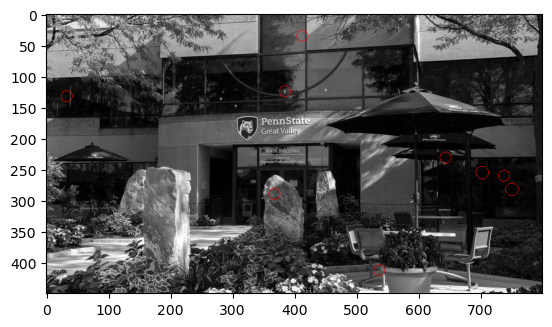

Number of points skipped: 1


In [152]:
corners, rad_vector = calcANMS(image, n_pts=10)

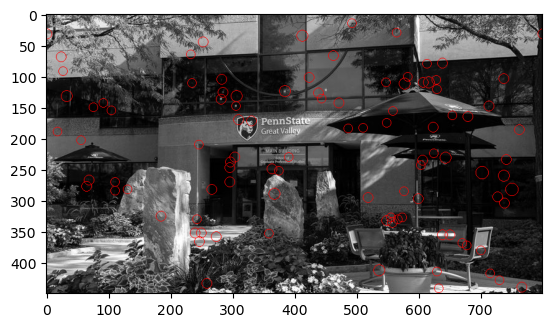

Number of points skipped: 1


In [153]:
corners, rad_vector = calcANMS(image, n_pts=100)

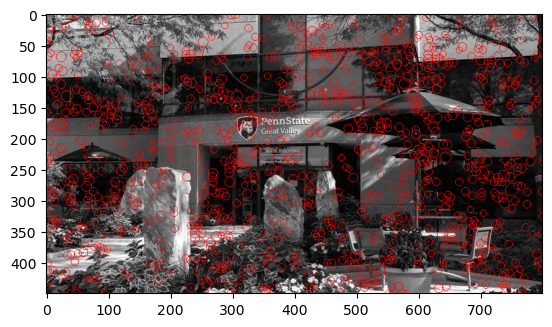

Number of points skipped: 35


In [154]:
corners, rad_vector = calcANMS(image, n_pts=1000)

# A further look at each step in the function

This explains how I arrived at using cdist rather than a double for loop with simpler sorting

In [25]:

# Copmute the Harris_response image to find peaks (corners)
harris_response = ski.feature.corner_harris(image)

# Find the corners.  Set min_distance=1 to find all possible peaks
#  Setting min_distnace = larger number effectivly implements the ANMS but I'll do it manually here
#  and compare results later to corner_peaks().
#  ski.feature.corner_peaks(): https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.corner_peaks
harris_corners = ski.feature.corner_peaks(harris_response, min_distance=1)

In [26]:
len(harris_corners)

8811

In [27]:
harris_corners[0:10]

array([[448, 743],
       [448, 299],
       [448, 750],
       [447, 426],
       [448, 505],
       [448, 754],
       [348, 576],
       [448, 708],
       [443, 287],
       [390, 231]], dtype=int64)

This sorting of the Harris corners no longer needs to be done.

By using the cdist vectorization on the radii, I am able to find
the corner to corner distance for each corner quickly.  Then I sort
these distances and return the index of the sort (which is inverted for decending).

By applying this index to both the radius vector and the Harris corners, I
have sorted both in one move.

In [28]:
# Sort Harris corners by intentisy (descending order)
#  There may be a better way to do this but this works well

'''
# Storage list for the intensities
intensity_list = []

# For each of the corners
for h_corner in harris_corners:
    # Append to the list the intensity at the corner
    intensity_list.append(image[h_corner[0], h_corner[1]])

ind = np.argsort(intensity_list) # Sorts ascending and returns the indecies of the sort
# Flip for decending
ind = np.flip(ind)

# Assign the sorted indexies to the harris_corner to sort the array
sorted_harris_corners = harris_corners[ind]
'''

'\n# Storage list for the intensities\nintensity_list = []\n\n# For each of the corners\nfor h_corner in harris_corners:\n    # Append to the list the intensity at the corner\n    intensity_list.append(image[h_corner[0], h_corner[1]])\n\nind = np.argsort(intensity_list) # Sorts ascending and returns the indecies of the sort\n# Flip for decending\nind = np.flip(ind)\n\n# Assign the sorted indexies to the harris_corner to sort the array\nsorted_harris_corners = harris_corners[ind]\n'

In [29]:
# Create the radius vector with same length as number of corners and set the first element to inf
# np.full_like() will allow an array to be built with the same shape as the harris_response
rad_vector = np.zeros_like(harris_corners)


# Don't have to do this due to the vectorized cdist and collapsing functions
# Assign the first element to a large value
# rad_vector[0][0] = 900000
# rad_vector[0][1] = 900000
# #Check the first element
# print(rad_vector[0], rad_vector[1])

This is the method described via the class notes.  It is extreamly long in computation time due to the nested loops.

It also requries an initial sorting of the harris corners, and then a secondary sorting through the radius vectors to help with the speed.

It is extreamly slow... I believe for my low-res image it took around 10 minutes.

In [30]:
# Corner looping - This is incredably slow as it needs to go
#  through nested for loops.  There is a faster method...
#  using scipy's cdist function and some clever matrix setups
#    By applying the cdist, I am able to forgo the multiple sorts needed
#    and can apply them both later.

'''
# From 2nd corner to the last
for i, c1 in enumerate(sorted_harris_corners[1:]):
    tmp_dist = 900000000
# From the first corner to the current corner
    for j, c2 in enumerate(sorted_harris_corners[0:i]):

        # Calculate the Euclidian distance using numpy linear algebra norms
        dist = np.linalg.norm(c2-c1)
        # Take the minimum of the distances
        tmp_dist = min(tmp_dist, dist)

    # Assign the minimum radius to the ith rad_vector
    rad_vector[i] = tmp_dist
'''

'\n# From 2nd corner to the last\nfor i, c1 in enumerate(sorted_harris_corners[1:]):\n    tmp_dist = 900000000\n# From the first corner to the current corner\n    for j, c2 in enumerate(sorted_harris_corners[0:i]):\n\n        # Calculate the Euclidian distance using numpy linear algebra norms\n        dist = np.linalg.norm(c2-c1)\n        # Take the minimum of the distances\n        tmp_dist = min(tmp_dist, dist)\n\n    # Assign the minimum radius to the ith rad_vector\n    rad_vector[i] = tmp_dist\n'

Instead of doing two sorts, I can implement cdist from scipy.  This will allow the radius vector to be calculated for every corner against every corner.

From here, I can argsort() the rad_vector and directly apply the indecies returned to the harris_corners and the rad_vector to put them in matched decending order.

In [31]:
# Maybe use a scipy method cdist: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html

# This is the faster scipy method with clever matrix setup

# Calculate the Euclidian distance between each corner point to each other corner point (creates a square matrix)
dist = cdist(harris_corners, harris_corners)
# Set the same corner to corner distance to infinity along the identity line
#  (we don't want zero here since we're not counting the corner against itself)
np.fill_diagonal(dist, np.inf)

# Show the distances so we know what we're doing
dist_df = pd.DataFrame(dist)
dist_df

,0,1,2,3,4,5,6,7,8,9,...,8801,8802,8803,8804,8805,8806,8807,8808,8809,8810
0,inf,444.000000,7.000000,317.001577,238.000000,11.000000,194.650970,35.000000,456.027411,515.274684,...,564.272984,592.426367,567.810708,489.902031,108.632408,107.205410,86.377080,166.207701,94.556861,204.002451
1,444.000000,inf,451.000000,127.003937,206.000000,455.000000,294.497878,409.000000,13.000000,89.375612,...,400.424774,439.209517,405.394869,104.403065,416.433668,423.467826,421.849499,350.201371,424.646912,240.002083
2,7.000000,451.000000,inf,324.001543,245.000000,4.000000,200.688814,42.000000,463.026997,522.230792,...,569.256533,597.175016,572.763476,496.762519,111.400180,109.562767,89.050547,171.125685,96.932967,211.002370
3,317.001577,127.003937,324.001543,inf,79.006329,328.001524,179.724790,282.001773,139.057542,203.160035,...,405.583530,443.829922,410.478989,189.678676,294.497878,301.424949,297.941269,234.446156,301.438219,113.000000
4,238.000000,206.000000,245.000000,79.006329,inf,249.000000,122.641755,203.000000,218.057332,280.071419,...,429.706877,466.061155,434.342031,261.090023,222.272355,228.973798,223.215143,171.840042,227.554389,34.014703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8806,107.205410,423.467826,109.562767,301.424949,228.973798,111.085553,134.014925,102.019606,433.979262,481.016632,...,471.492312,496.904417,474.647237,447.017897,7.071068,inf,21.213203,83.952367,12.649111,198.600101
8807,86.377080,421.849499,89.050547,297.941269,223.215143,90.785461,138.311243,81.154174,432.726241,482.548443,...,487.225820,513.454964,490.493629,450.320997,22.360680,21.213203,inf,93.520051,9.055385,191.509791
8808,166.207701,350.201371,171.125685,234.446156,171.840042,174.000000,55.713553,144.222051,359.869421,401.812145,...,398.131888,426.279251,401.639142,365.662413,77.369245,83.952367,93.520051,inf,91.082380,148.600135
8809,94.556861,424.646912,96.932967,301.438219,227.554389,98.488578,138.361844,90.199778,435.377997,484.058881,...,482.187723,507.986220,485.396745,451.070948,15.556349,12.649111,9.055385,91.082380,inf,196.331353


In [32]:
# Take the minimum of each row to find the shortest radius vector for each corner-to-corner
rad_vec = np.min(dist, axis=1)

# Show the first 10 radius vectors for sanity
rad_vec[0:10]

array([6.        , 5.65685425, 4.        , 6.        , 3.16227766,
       4.        , 6.32455532, 6.40312424, 4.24264069, 4.47213595])

In [33]:
# Sort radius vectors by distance (descending order)
#  There may be a better way to do this but this works well and is fast enough

# Storage list for the intensities
rad_list = []

# For each of the corners
for r_v in rad_vec:
    # Append to the list the intensity at the corner
    rad_list.append(r_v)

ind = np.argsort(rad_list) # Sorts ascending and returns the indecies of the sort
# Flip for decending
ind = np.flip(ind)

# Assign the sorted indexies to the harris_corner and rad_vector to sort the arrays
sorted_harris_corners = harris_corners[ind]

sorted_rad_vec = rad_vec[ind]



In [155]:
# Create a copy of the origional image that we're going to modify to show the ANMS items
marked_image = np.copy(image)

# Convert the grayscale back to a 3 channel color so we can plot red circles
marked_image = ski.color.gray2rgb(marked_image)

In [156]:
# Take the tuple from the harris corners and pull them apart for a later for loop
sorted_x_centers = sorted_harris_corners[0:,0]
sorted_y_centers = sorted_harris_corners[0:,1]

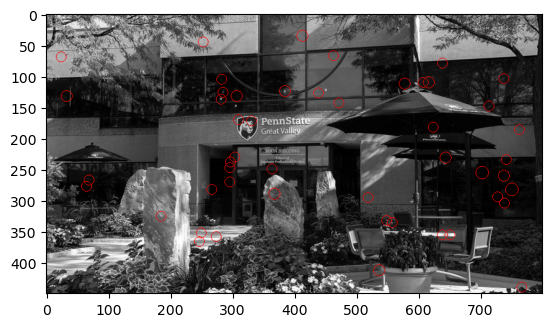

Number of points skipped: 1


In [158]:
# Make circles at each of the 'n' radii for on the image

fig, ax = plt.subplots(ncols=1, nrows=1)

# Count the number of cirlces that will occur outside of the image
skipped = 0

# for n_points worth of x,y points with a radius, create a circle
for x_pt, y_pt, rad in zip(sorted_x_centers[:n_points], sorted_y_centers[:n_points], sorted_rad_vec[:n_points]):
    # This provides back in row, column
    c_y, c_x = ski.draw.circle_perimeter(int(y_pt), int(x_pt), int(rad))#, shape=marked_image.shape)

    # Mark up the image with a red circle
    #  Note: the circle is [R,G,B] in float values {0,1}

    # If any location on the cirlce radius is outside of the image, do not plot that cirlce.
    if np.any(c_y>=800) or np.any(c_x>=450):
        skipped += 1
    else:
        marked_image[c_x, c_y] = (1,0,0) # the row, column from circle_permieter needs flipped again for plotting


# Display the marked up image
ax.imshow(marked_image)
plt.show()

print(f'Number of points skipped: {skipped}')

I am going to try to replicate my results from ANMS with just the skimage library

In [160]:
hcs = ski.feature.corner_harris(image)

In [179]:
peaks = ski.feature.corner_peaks(hcs, min_distance=30)


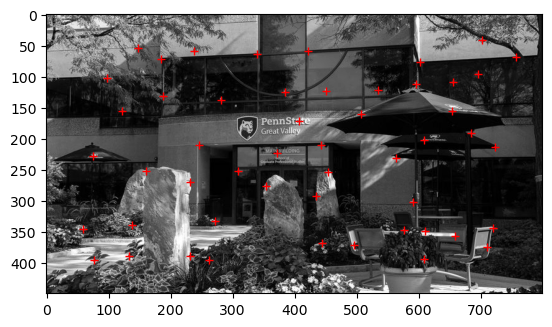

In [181]:
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
ax.plot(peaks[:, 1], peaks[:,0], color='red', marker='+', linestyle='None')
plt.show()

corner_peaks differs from skimage.feature.peak_local_max in that it suppresses multiple connected peaks with the same accumulator value.

See: https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.corner_peaks

In [182]:
local_peaks = ski.feature.peak_local_max(hcs, min_distance=30)

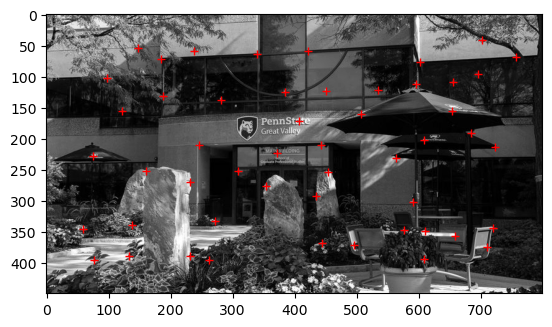

In [183]:
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
ax.plot(local_peaks[:, 1], local_peaks[:,0], color='red', marker='+', linestyle='None')
plt.show()

Notice that the min_distance does not correspond exactly to what ANMS is doing.  ANMS is finding the peaks with the largest radii and plotting them.  corner_peaks and peak_local_max are finding peaks that are sperated by some minimum distance from other peaks at a certain threshold.

This would be similar (though not exactly like) plotting ANMS and then removing radii that overlapped.